In [1]:
# Cell 1: Imports and Configuration
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision import models
from pathlib import Path
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm.auto import tqdm
from IPython.display import clear_output

# --- Configuration ---
CONFIG = {
    "experiment_name": "Exp05_TL_ResNet34_Attention_HalfSplit",
    "image_size": 256,
    "batch_size": 12,
    "num_workers": 0,
    
    # Training Schedule
    "warmup_epochs": 10,       # Phase 1: Frozen Encoder
    "finetune_epochs": 90,     # Phase 2: Unfrozen (Total 100)
    "early_stopping_patience": 30,
    
    # Differential Learning Rates
    "lr_encoder": 1e-5,        # Slow learning for pretrained weights
    "lr_decoder": 1e-4,        # Fast learning for new weights
    
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "manifest_path": "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv",
    "data_root": "../data/UT-EndoMRI/D2_Half_Split",
    "save_dir": "../models/exp05_tl_resnet34"
}

# Create save directory
Path(CONFIG["save_dir"]).mkdir(parents=True, exist_ok=True)
(Path(CONFIG["save_dir"]) / "checkpoints").mkdir(parents=True, exist_ok=True)

print(f"Running {CONFIG['experiment_name']} on {CONFIG['device']}")

Running Exp05_TL_ResNet34_Attention_HalfSplit on cuda


In [2]:
# Cell 2

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

In [3]:
# Cell 3

class OvaryDataset(Dataset):
    def __init__(self, root_dir, manifest_path, split, image_size=256, augment=False):
        self.root_dir = Path(root_dir)
        self.df = pd.read_csv(manifest_path)
        
        # Filter by split (Using the logic: Fold 0=Test, Fold 1=Val, Fold 2-4=Train)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        
        self.image_size = image_size
        self.augment = augment
        self.samples = [] 
        
        print(f"Initializing {split.upper()} dataset from {self.root_dir.name}...")
        
        for idx, row in self.df.iterrows():
            # Robust path finding
            img_name = Path(row['t2fs_path']).name
            msk_name = Path(row['ov_path']).name
            
            img_p = self.root_dir / img_name
            msk_p = self.root_dir / msk_name
            
            if not img_p.exists():
                print(f"  WARNING: File not found {img_p}")
                continue
                
            # Pre-scan for valid slices
            try:
                msk_vol = nib.load(str(msk_p)).get_fdata()
                z_sums = np.sum(msk_vol, axis=(0, 1))
                valid_slices = np.where(z_sums > 0)[0]
                
                for z in valid_slices:
                    self.samples.append({
                        'img_path': str(img_p),
                        'msk_path': str(msk_p),
                        'slice_idx': z,
                        'pid': row['pid']
                    })
            except Exception as e:
                print(f"  Error loading {row['pid']}: {e}")
                
        print(f"  Found {len(self.samples)} positive slices.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        info = self.samples[idx]
        
        # Load Volumes
        img_vol = nib.load(info['img_path']).get_fdata()
        msk_vol = nib.load(info['msk_path']).get_fdata()
        
        # Extract Slice
        z = info['slice_idx']
        img = img_vol[:, :, z]
        msk = msk_vol[:, :, z]
        
        # 1. Robust Min-Max Normalization (Standard Preprocessing)
        p1 = np.percentile(img, 1)
        p99 = np.percentile(img, 99)
        img = np.clip(img, p1, p99)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # 2. Binarize Mask
        msk = (msk > 0).astype(np.float32)
        
        # 3. To Tensor (H, W) -> (C, H, W)
        # Nibabel is (W, H), transpose to (H, W)
        img = torch.from_numpy(img.T).float().unsqueeze(0)
        msk = torch.from_numpy(msk.T).float().unsqueeze(0)
        
        # 4. Resize
        img = TF.resize(img, [self.image_size, self.image_size], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
        msk = TF.resize(msk, [self.image_size, self.image_size], interpolation=T.InterpolationMode.NEAREST, antialias=True)
        
        # 5. Augmentation
        if self.augment:
            # Random Rotation
            angle = random.uniform(-25, 25)
            img = TF.rotate(img, angle, interpolation=T.InterpolationMode.BILINEAR)
            msk = TF.rotate(msk, angle, interpolation=T.InterpolationMode.NEAREST)
            
            # Random Translation (+/- 10%)
            max_shift = int(self.image_size * 0.1)
            t_x = random.randint(-max_shift, max_shift)
            t_y = random.randint(-max_shift, max_shift)
            img = TF.affine(img, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.BILINEAR)
            msk = TF.affine(msk, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.NEAREST)
            
        return img, msk

# Instantiate DataLoaders
train_ds = OvaryDataset(CONFIG["data_root"], CONFIG["manifest_path"], split='train', augment=True)
val_ds = OvaryDataset(CONFIG["data_root"], CONFIG["manifest_path"], split='val', augment=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

Initializing TRAIN dataset from D2_Half_Split...
  Found 101 positive slices.
Initializing VAL dataset from D2_Half_Split...
  Found 38 positive slices.


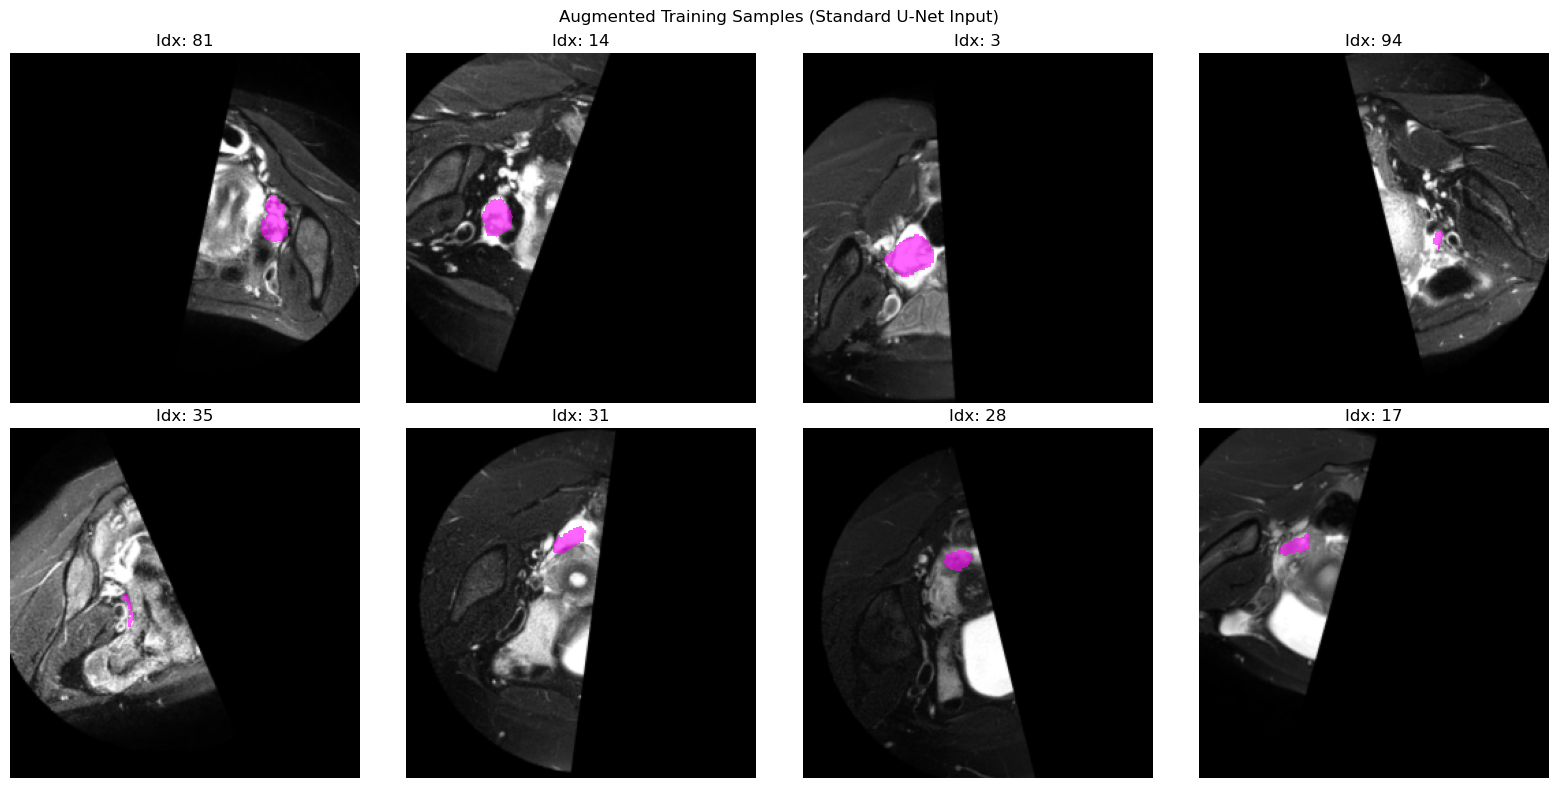

In [4]:
# Cell 4

# Pull a few samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

indices = [random.randint(0, len(train_ds)-1) for _ in range(8)]

for ax, idx in zip(axes, indices):
    img, msk = train_ds[idx]
    
    img_np = img.squeeze().numpy()
    msk_np = msk.squeeze().numpy()
    
    ax.imshow(img_np, cmap='gray', origin='lower')
    # Overlay mask in red/pink
    masked_overlay = np.ma.masked_where(msk_np == 0, msk_np)
    ax.imshow(masked_overlay, cmap='spring', alpha=0.6, origin='lower')
    
    ax.set_title(f"Idx: {idx}")
    ax.axis('off')

plt.suptitle("Augmented Training Samples (Standard U-Net Input)")
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Transfer Learning Model (ResNet34 + Attention U-Net Decoder)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class TLAttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super(TLAttentionUNet, self).__init__()
        
        # 1. Load Pretrained ResNet34
        # We grab the layers we need for the encoder path
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        
        # Encoder Blocks
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # 64 ch
        self.enc1 = resnet.maxpool # 64 ch
        self.enc2 = resnet.layer1  # 64 ch
        self.enc3 = resnet.layer2  # 128 ch
        self.enc4 = resnet.layer3  # 256 ch
        self.center = resnet.layer4 # 512 ch
        
        # Decoder Blocks (with Attention)
        # Up 1: Center(512) -> Enc4(256)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.conv1 = DoubleConv(512, 256) # 256+256 = 512 input
        
        # Up 2: -> Enc3(128)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.conv2 = DoubleConv(256, 128) # 128+128 = 256 input
        
        # Up 3: -> Enc2(64)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv3 = DoubleConv(128, 64) # 64+64 = 128 input
        
        # Up 4: -> Enc0(64) - Note: ResNet skips Layer1/MaxPool sometimes share sizes
        # We upsample to the size of enc0
        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv4 = DoubleConv(128, 64) 
        
        # Final Output
        # We might need one more upsample to get back to original 256x256 if enc0 is 128x128
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Adapt Grayscale to RGB (Repeat channels)
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
            
        # Encoder
        e0 = self.enc0(x)      # 128x128, 64ch
        e1 = self.enc1(e0)     # 64x64, 64ch (MaxPool)
        e2 = self.enc2(e1)     # 64x64, 64ch (Layer 1)
        e3 = self.enc3(e2)     # 32x32, 128ch (Layer 2)
        e4 = self.enc4(e3)     # 16x16, 256ch (Layer 3)
        c  = self.center(e4)   # 8x8, 512ch   (Layer 4)
        
        # Decoder
        d1 = self.up1(c)       # -> 16x16
        s1 = self.att1(g=d1, x=e4)
        d1 = torch.cat([d1, s1], dim=1)
        d1 = self.conv1(d1)
        
        d2 = self.up2(d1)      # -> 32x32
        s2 = self.att2(g=d2, x=e3)
        d2 = torch.cat([d2, s2], dim=1)
        d2 = self.conv2(d2)
        
        d3 = self.up3(d2)      # -> 64x64
        # Note: e2 and e1 are same size usually in ResNet34, we use e2 (Layer 1 output)
        s3 = self.att3(g=d3, x=e2) 
        d3 = torch.cat([d3, s3], dim=1)
        d3 = self.conv3(d3)
        
        d4 = self.up4(d3)      # -> 128x128
        s4 = self.att4(g=d4, x=e0)
        d4 = torch.cat([d4, s4], dim=1)
        d4 = self.conv4(d4)
        
        # Final Upsample to 256x256 (Since e0 was 128x128)
        logits = self.outc(d4)
        logits = F.interpolate(logits, scale_factor=2, mode='bilinear', align_corners=True)
        
        return logits

# Initialize
model = TLAttentionUNet(n_classes=1).to(CONFIG["device"])
print("Transfer Learning Model (ResNet34 + Attention) Initialized.")

Transfer Learning Model (ResNet34 + Attention) Initialized.


In [6]:
# Cell 6: Loss Function
# Note: Optimizer is defined inside the Training Loop (Cell 7) 
# because it changes between Warmup and Finetune phases.

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs_sigmoid = torch.sigmoid(inputs)
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        
        return bce + dice_loss

criterion = DiceBCELoss()
print("Loss Function Initialized.")

Loss Function Initialized.


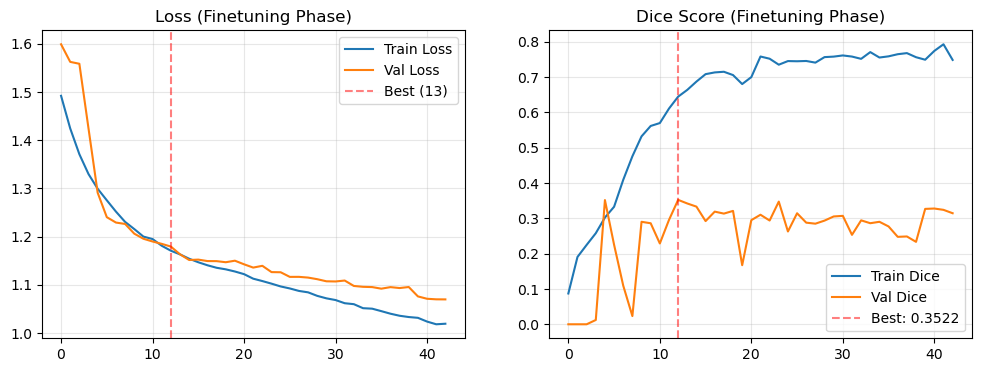

Epoch 43 | Train Dice: 0.7484 | Val Dice: 0.3144
Early Stopping triggered at epoch 43
Training Complete.


In [7]:
# Cell 7: Two-Phase Training Loop (Warmup -> Finetune)

# Helper functions (Keep these same as before)
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        intersection = (preds * masks).sum()
        dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)
        epoch_dice += dice.item()
    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection = (preds * masks).sum()
            dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)
            epoch_dice += dice.item()
    return epoch_loss / len(loader), epoch_dice / len(loader)

def plot_training_history(history, best_epoch, best_val_dice, phase_text):
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    if best_epoch is not None:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best ({best_epoch+1})')
    plt.title(f'Loss ({phase_text})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    if best_epoch is not None:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_val_dice:.4f}')
    plt.title(f'Dice Score ({phase_text})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- TRAINING LOGIC ---

history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
best_val_dice = 0.0
best_epoch = None
patience_counter = 0

# === PHASE 1: WARMUP (Frozen Encoder) ===
print(f"\n=== PHASE 1: WARMUP ({CONFIG['warmup_epochs']} Epochs) ===")
print("Freezing Encoder...")

# Freeze ResNet layers
# In our class, these are enc0, enc1, enc2, enc3, enc4, center
for param in model.enc0.parameters(): param.requires_grad = False
for param in model.enc2.parameters(): param.requires_grad = False
for param in model.enc3.parameters(): param.requires_grad = False
for param in model.enc4.parameters(): param.requires_grad = False
for param in model.center.parameters(): param.requires_grad = False

# Optimizer for Decoder Only
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CONFIG["lr_decoder"])

for epoch in range(CONFIG['warmup_epochs']):
    t_loss, t_dice = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG["device"])
    v_loss, v_dice = validate(model, val_loader, criterion, CONFIG["device"])
    
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_dice'].append(t_dice)
    history['val_dice'].append(v_dice)
    
    # Track best model even in warmup
    if v_dice > best_val_dice:
        best_val_dice = v_dice
        best_epoch = epoch
        torch.save(model.state_dict(), Path(CONFIG["save_dir"]) / "best_model.pth")
    
    plot_training_history(history, best_epoch, best_val_dice, "Warmup Phase")
    print(f"Warmup Epoch {epoch+1} | Val Dice: {v_dice:.4f}")


# === PHASE 2: FINETUNE (Unfrozen) ===
print(f"\n=== PHASE 2: FINETUNING ({CONFIG['finetune_epochs']} Epochs) ===")
print("Unfreezing Encoder...")

# Unfreeze everything
for param in model.parameters():
    param.requires_grad = True

# Differential Learning Rates
optimizer = torch.optim.AdamW([
    {'params': model.enc0.parameters(), 'lr': CONFIG['lr_encoder']},
    {'params': model.enc2.parameters(), 'lr': CONFIG['lr_encoder']},
    {'params': model.enc3.parameters(), 'lr': CONFIG['lr_encoder']},
    {'params': model.enc4.parameters(), 'lr': CONFIG['lr_encoder']},
    {'params': model.center.parameters(), 'lr': CONFIG['lr_encoder']},
    # Decoder parts will use the default lr (lr_decoder)
    {'params': model.up1.parameters()},
    {'params': model.att1.parameters()},
    {'params': model.conv1.parameters()},
    {'params': model.up2.parameters()},
    {'params': model.att2.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.up3.parameters()},
    {'params': model.att3.parameters()},
    {'params': model.conv3.parameters()},
    {'params': model.up4.parameters()},
    {'params': model.att4.parameters()},
    {'params': model.conv4.parameters()},
    {'params': model.outc.parameters()}
], lr=CONFIG['lr_decoder'], weight_decay=1e-5)

# Reset patience for phase 2
patience_counter = 0 

for epoch in range(CONFIG['warmup_epochs'], CONFIG['warmup_epochs'] + CONFIG['finetune_epochs']):
    t_loss, t_dice = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG["device"])
    v_loss, v_dice = validate(model, val_loader, criterion, CONFIG["device"])
    
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_dice'].append(t_dice)
    history['val_dice'].append(v_dice)
    
    if v_dice > best_val_dice:
        best_val_dice = v_dice
        best_epoch = epoch
        torch.save(model.state_dict(), Path(CONFIG["save_dir"]) / "best_model.pth")
        new_best_msg = f" >>> New Best! ({best_val_dice:.4f})"
        patience_counter = 0
    else:
        new_best_msg = ""
        patience_counter += 1
        
    plot_training_history(history, best_epoch, best_val_dice, "Finetuning Phase")
    print(f"Epoch {epoch+1} | Train Dice: {t_dice:.4f} | Val Dice: {v_dice:.4f}{new_best_msg}")
    
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"Early Stopping triggered at epoch {epoch+1}")
        break

torch.save(model.state_dict(), Path(CONFIG["save_dir"]) / "last_model.pth")
print("Training Complete.")

In [ ]:
# # Cell 8: Training Curves with Best Model Indicator

# # Find the epoch with the best validation dice
# best_epoch_idx = np.argmax(history['val_dice'])
# best_epoch_val = history['val_dice'][best_epoch_idx]

# plt.figure(figsize=(12, 5))

# # Loss Plot
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Val Loss')
# # Add vertical line
# plt.axvline(x=best_epoch_idx, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch_idx+1})')
# plt.title('Loss Curves')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Dice Plot
# plt.subplot(1, 2, 2)
# plt.plot(history['train_dice'], label='Train Dice')
# plt.plot(history['val_dice'], label='Val Dice')
# # Add vertical line
# plt.axvline(x=best_epoch_idx, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_epoch_val:.4f}')
# plt.title('Dice Score Curves')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

C:\Users\lytten\AppData\Local\Temp\ipykernel_22176\2862862664.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Visualizing: best_model.pth (Best Auto-Selected Model)


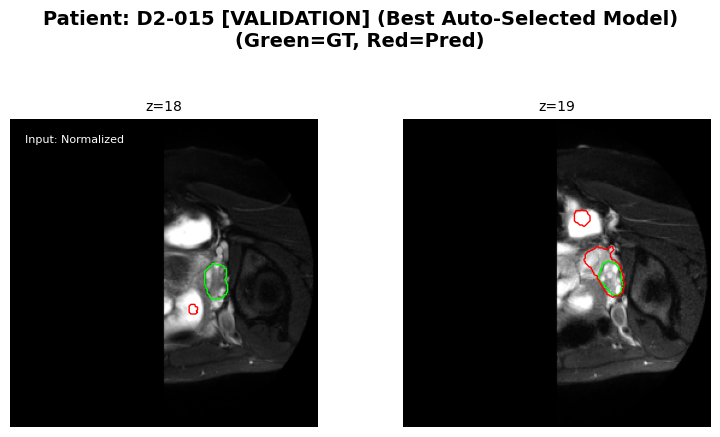

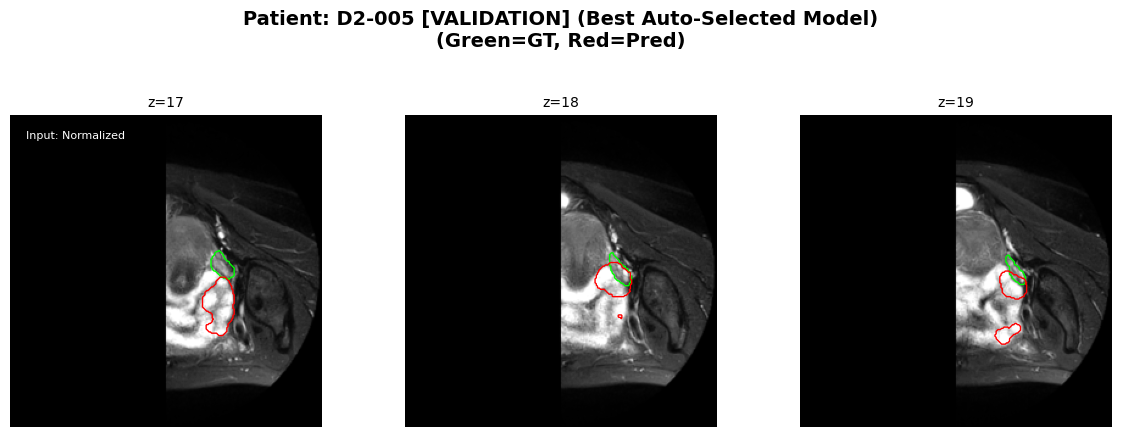

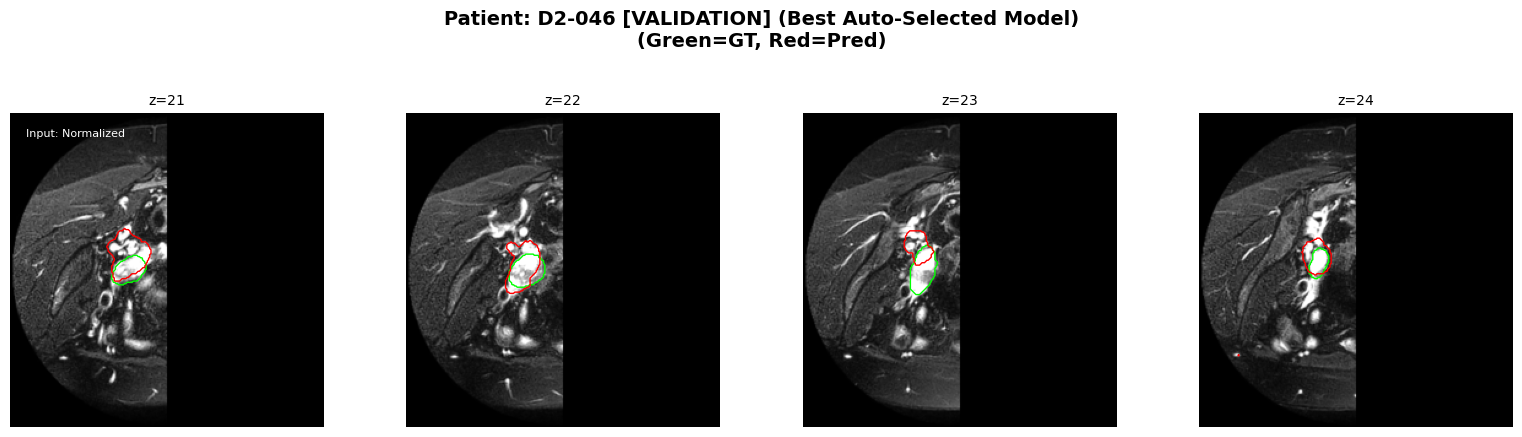

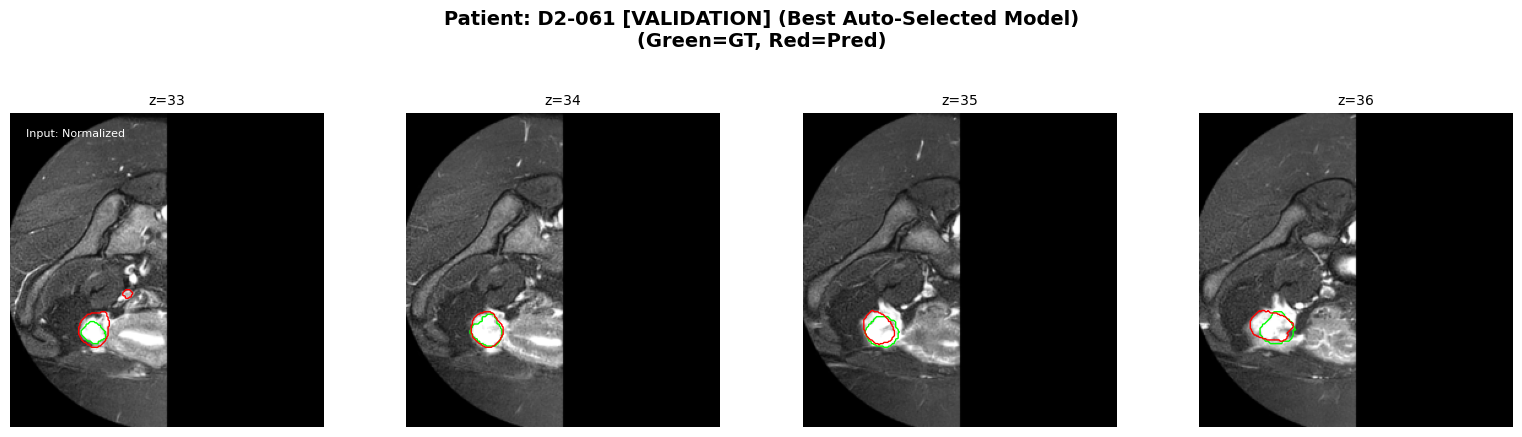

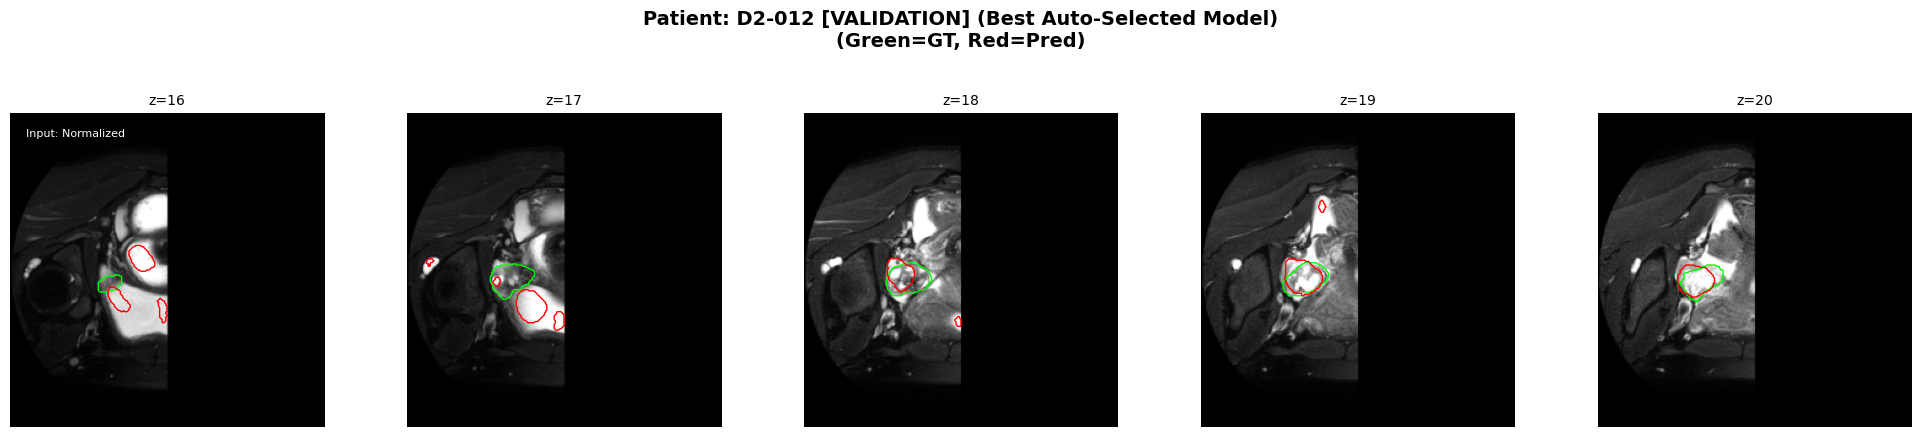

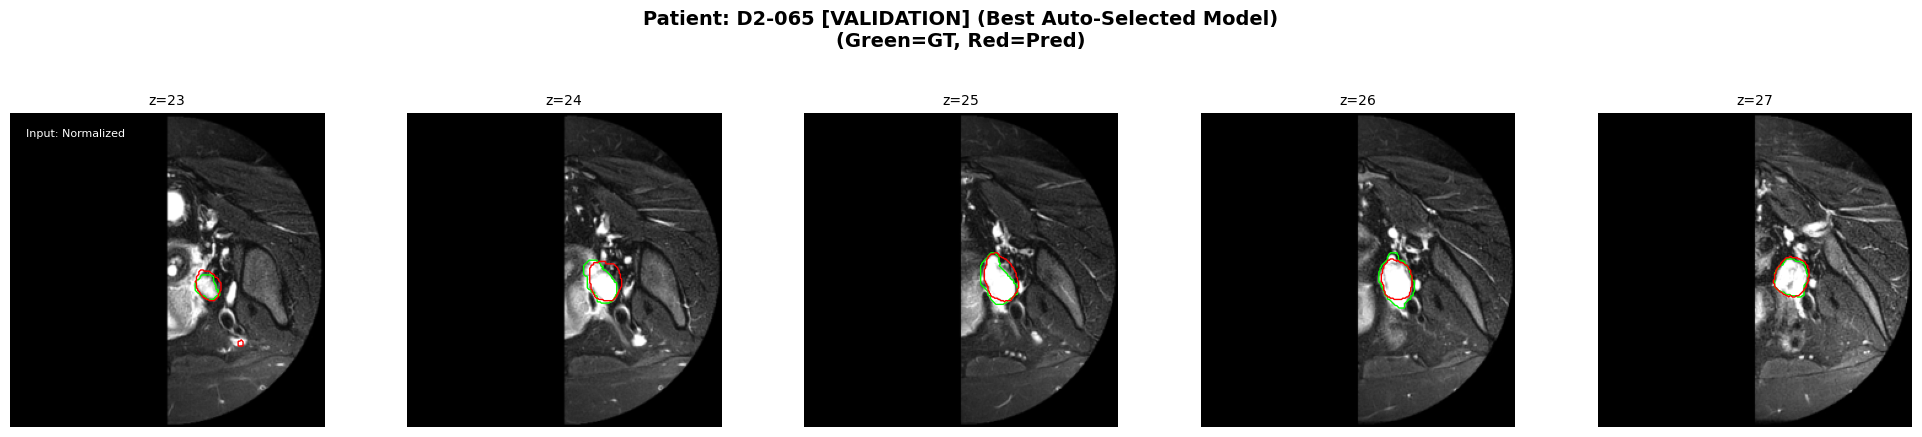

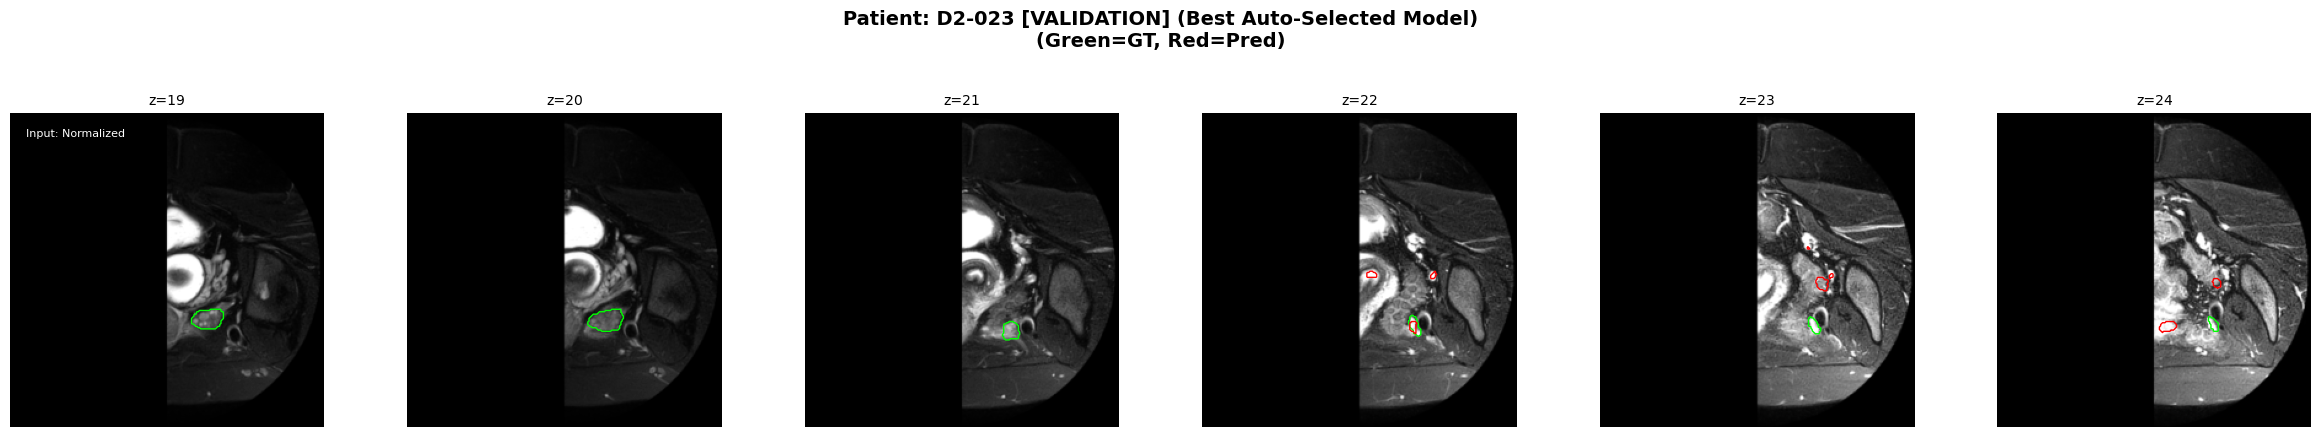

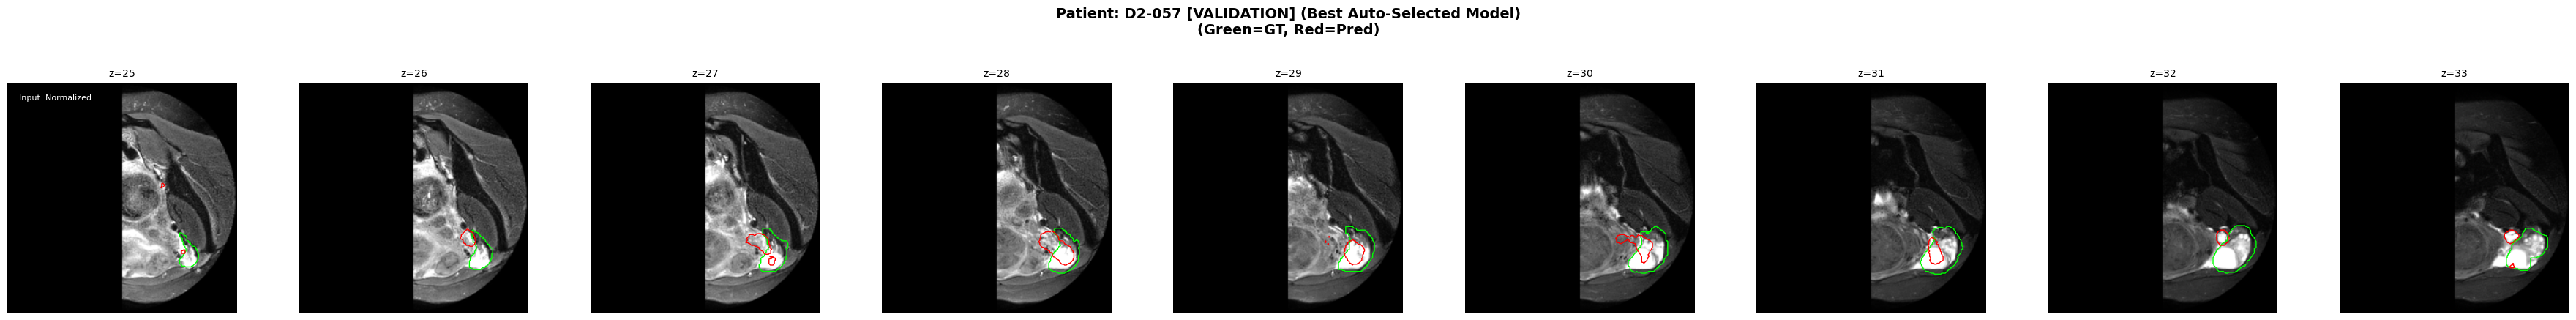

In [8]:
# Cell 9: Qualitative Analysis (Validation Set)
# Green = Ground Truth | Red = Prediction

# --- USER SETTING ---
VIEW_EPOCH = None  # Set to None for "Best Model", or an integer (e.g., 30)
# --------------------

def visualize_validation_results(save_dir, dataset, device, epoch=None):
    # Determine which file to load
    if epoch is None:
        model_path = Path(save_dir) / "best_model.pth"
        title_suffix = "(Best Auto-Selected Model)"
    else:
        model_path = Path(save_dir) / "checkpoints" / f"epoch_{epoch}.pth"
        title_suffix = f"(Manual Checkpoint: Epoch {epoch})"
    
    if not model_path.exists():
        print(f"Error: Model not found at {model_path}")
        return

    # --- CHANGE: Use Transfer Learning Model ---
    model = TLAttentionUNet(n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    print(f"Visualizing: {model_path.name} {title_suffix}")
    
    # Group by patient
    patient_indices = {}
    for i, sample in enumerate(dataset.samples):
        pid = sample['pid']
        if pid not in patient_indices:
            patient_indices[pid] = []
        patient_indices[pid].append(i)
        
    for pid, indices in patient_indices.items():
        indices.sort(key=lambda i: dataset.samples[i]['slice_idx'])
        n_slices = len(indices)
        
        fig, axes = plt.subplots(1, n_slices, figsize=(4 * n_slices, 4))
        if n_slices == 1: axes = [axes]
        
        fig.suptitle(f"Patient: {pid} [VALIDATION] {title_suffix}\n(Green=GT, Red=Pred)", y=1.08, fontsize=14, fontweight='bold')
        
        with torch.no_grad():
            for ax, ds_idx in zip(axes, indices):
                img, msk = dataset[ds_idx]
                input_tensor = img.unsqueeze(0).to(device)
                
                logits = model(input_tensor)
                pred = (torch.sigmoid(logits) > 0.5).float().cpu().squeeze().numpy()
                
                img_np = img.squeeze().numpy()
                msk_np = msk.squeeze().numpy()
                
                # Show Preprocessed Input
                ax.imshow(img_np, cmap='gray', origin='lower')
                
                # GT Contour
                if np.sum(msk_np) > 0:
                    ax.contour(msk_np, colors='lime', linewidths=1.0, levels=[0.5])
                
                # Pred Contour
                if np.sum(pred) > 0:
                    ax.contour(pred, colors='red', linewidths=1.0, levels=[0.5])
                
                slice_idx = dataset.samples[ds_idx]['slice_idx']
                if ax == axes[0]:
                    ax.text(0.05, 0.95, "Input: Normalized", transform=ax.transAxes, color='white', fontsize=8, verticalalignment='top')
                
                ax.set_title(f"z={slice_idx}", fontsize=10)
                ax.axis('off')

        plt.tight_layout()
        plt.show()

# Run Visualization
visualize_validation_results(CONFIG["save_dir"], val_ds, CONFIG["device"], epoch=VIEW_EPOCH)

C:\Users\lytten\AppData\Local\Temp\ipykernel_22176\3354214491.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Initializing TEST dataset from D2_Half_Split...
  Found 38 positive slices.
Evaluating Test Set (Fold 0) - 38 slices total.
Generating 3D Scores and Visualizations...



Patients:   0%|          | 0/8 [00:00<?, ?it/s]

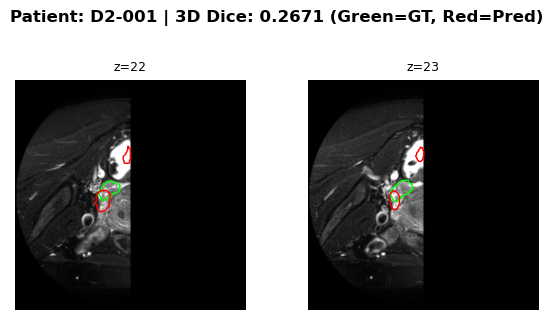

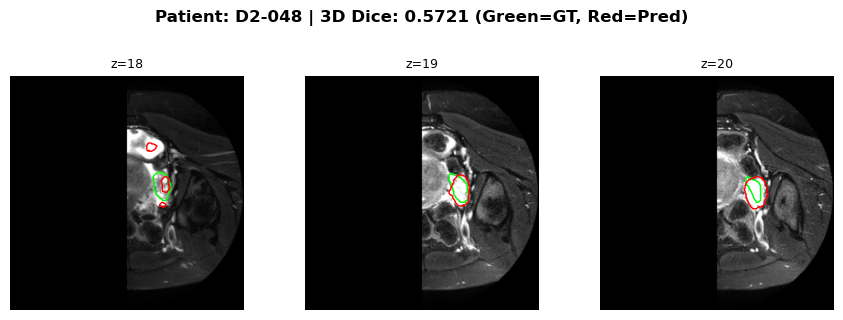

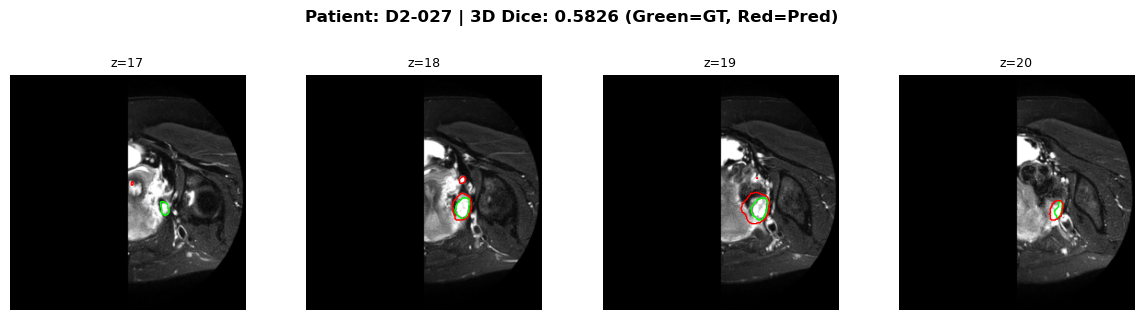

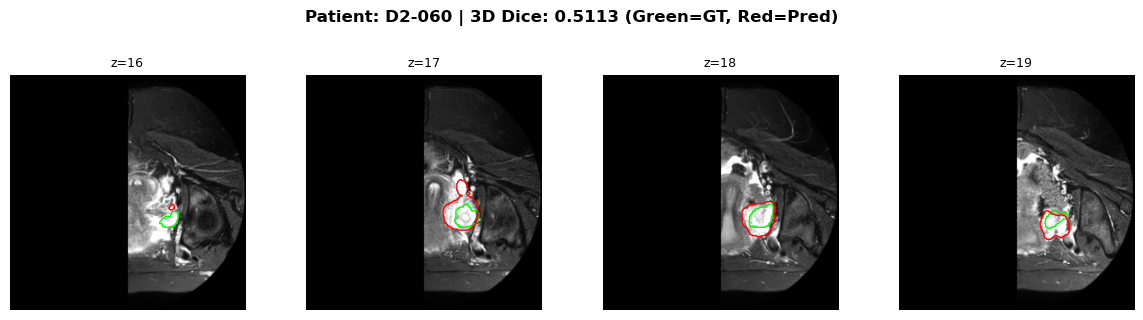

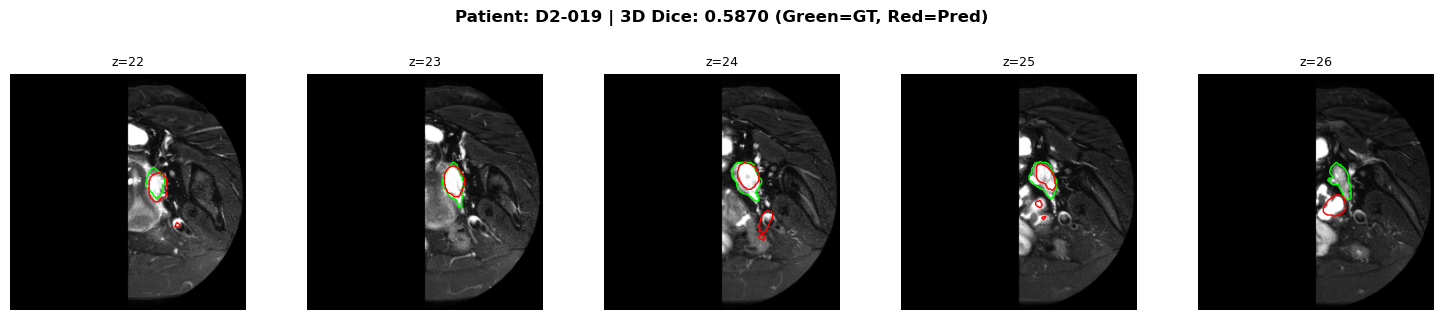

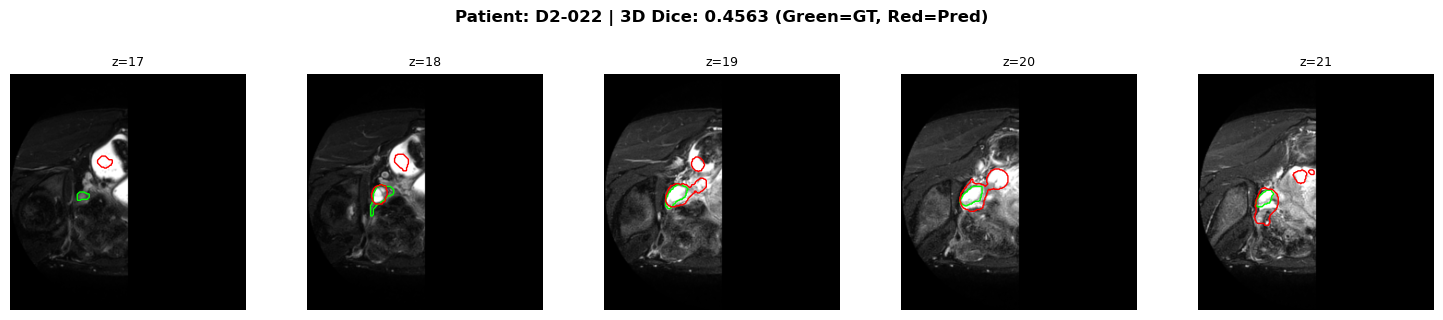

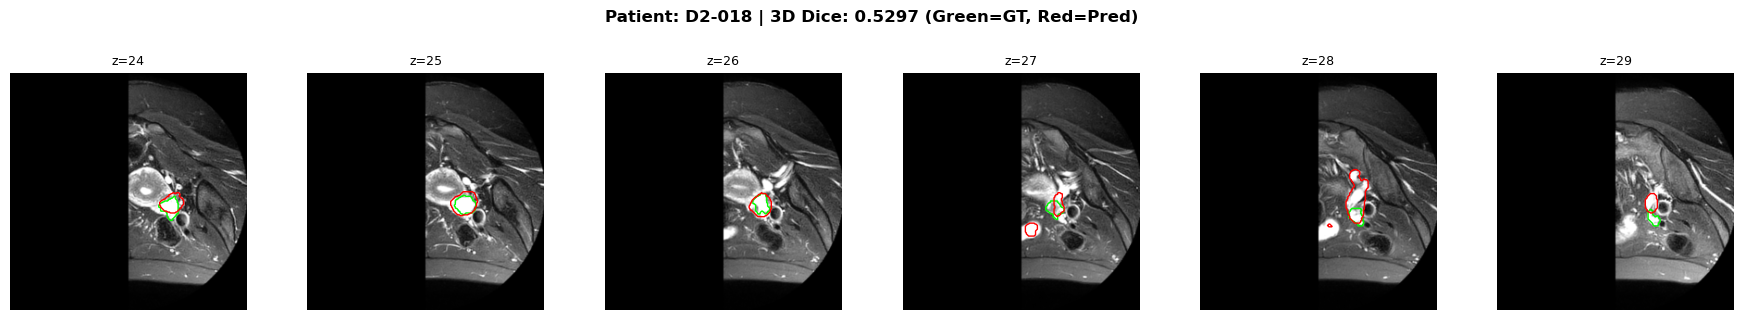

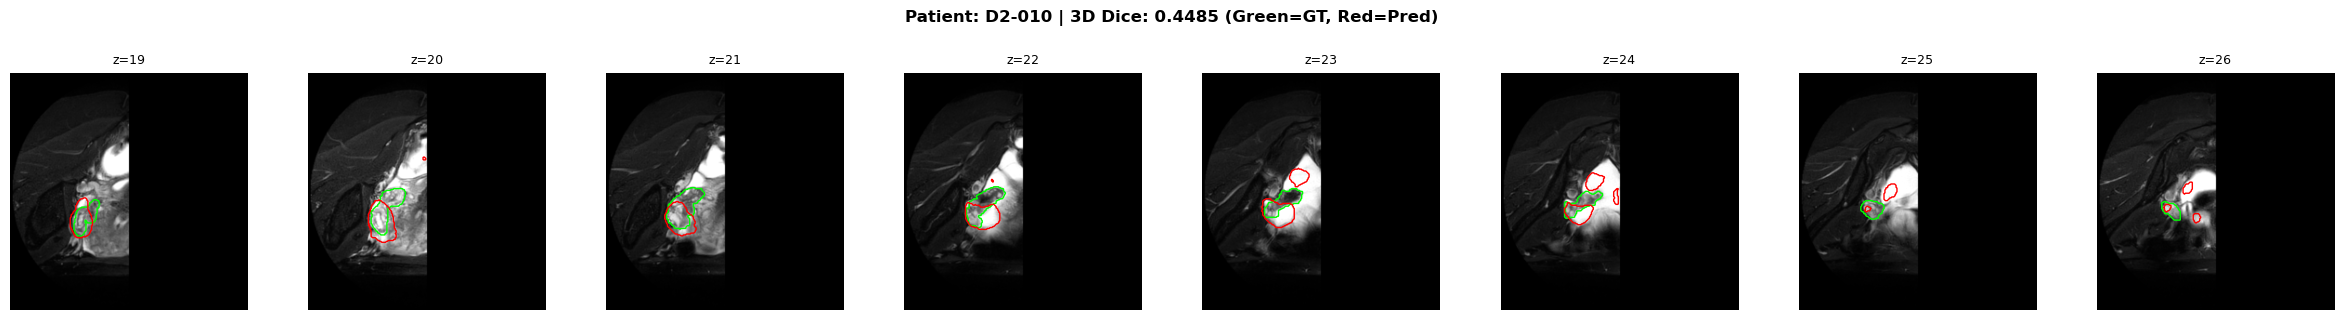


OVERALL TEST SET PERFORMANCE
Mean 3D Dice: 0.4943 ± 0.0995


In [9]:
# Cell 10: Quantitative & Qualitative Evaluation on Test Set
# We reconstruct 3D volumes for the Test Set (Fold 0), calculate the clinical Dice score,
# and visualize the results for every patient.

def evaluate_test_set_3d(model_path, root_dir, manifest_path, device):
    # --- CHANGE: Use Transfer Learning Model ---
    model = TLAttentionUNet(n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2. Load TEST Set (Fold 0)
    test_ds = OvaryDataset(root_dir, manifest_path, split='test', augment=False)
    
    print(f"Evaluating Test Set (Fold 0) - {len(test_ds)} slices total.")
    print("Generating 3D Scores and Visualizations...\n")
    
    # Group by patient
    patient_data = {}
    for i, sample in enumerate(test_ds.samples):
        pid = sample['pid']
        if pid not in patient_data:
            patient_data[pid] = []
        patient_data[pid].append(sample)
        
    patient_dice_scores = []
    
    with torch.no_grad():
        for pid, samples in tqdm(patient_data.items(), desc="Patients"):
            # Sort by slice index
            samples.sort(key=lambda x: x['slice_idx'])
            
            vol_pred = []
            vol_gt = []
            vol_imgs = [] 
            
            # --- Prediction Loop ---
            for sample in samples:
                img_vol = nib.load(sample['img_path']).get_fdata()
                msk_vol = nib.load(sample['msk_path']).get_fdata()
                z = sample['slice_idx']
                
                img = img_vol[:, :, z]
                msk = msk_vol[:, :, z]
                
                # --- STANDARD PREPROCESSING (Min-Max) ---
                # (Reverting RAovSeg logic to standard)
                p1 = np.percentile(img, 1)
                p99 = np.percentile(img, 99)
                img = np.clip(img, p1, p99)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                msk = (msk > 0).astype(np.float32)
                # ----------------------------------------
                
                vol_imgs.append(img)
                
                # Predict
                img_tensor = torch.from_numpy(img.T).float().unsqueeze(0).unsqueeze(0).to(device)
                img_tensor = TF.resize(img_tensor, [256, 256], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
                
                logits = model(img_tensor)
                pred = (torch.sigmoid(logits) > 0.5).float().cpu().numpy().squeeze()
                
                # Resize GT
                msk_tensor = torch.from_numpy(msk.T).float().unsqueeze(0).unsqueeze(0)
                msk_resized = TF.resize(msk_tensor, [256, 256], interpolation=T.InterpolationMode.NEAREST, antialias=True)
                gt = msk_resized.numpy().squeeze()
                
                vol_pred.append(pred)
                vol_gt.append(gt)
            
            # --- 3D Scoring ---
            vol_pred = np.array(vol_pred)
            vol_gt = np.array(vol_gt)
            
            intersection = np.sum(vol_pred * vol_gt)
            total = np.sum(vol_pred) + np.sum(vol_gt)
            dice = (2.0 * intersection) / (total + 1e-8)
            patient_dice_scores.append(dice)
            
            # --- Visualization ---
            active_indices = [i for i in range(len(vol_gt)) if np.sum(vol_gt[i]) > 0 or np.sum(vol_pred[i]) > 0]
            if not active_indices:
                active_indices = list(range(len(vol_gt) // 2 - 2, len(vol_gt) // 2 + 2))
                
            if len(active_indices) > 8:
                step = len(active_indices) // 8
                display_indices = active_indices[::step][:8]
            else:
                display_indices = active_indices
            
            n_slices = len(display_indices)
            fig, axes = plt.subplots(1, n_slices, figsize=(3 * n_slices, 3))
            if n_slices == 1: axes = [axes]
            
            fig.suptitle(f"Patient: {pid} | 3D Dice: {dice:.4f} (Green=GT, Red=Pred)", y=1.05, fontsize=12, fontweight='bold')
            
            for ax, idx in zip(axes, display_indices):
                img_disp_t = torch.from_numpy(vol_imgs[idx].T).float().unsqueeze(0).unsqueeze(0)
                img_disp_t = TF.resize(img_disp_t, [256, 256], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
                img_disp = img_disp_t.squeeze().numpy()
                
                ax.imshow(img_disp, cmap='gray', origin='lower')
                
                if np.sum(vol_gt[idx]) > 0:
                    ax.contour(vol_gt[idx], colors='lime', linewidths=1.0, levels=[0.5])
                
                if np.sum(vol_pred[idx]) > 0:
                    ax.contour(vol_pred[idx], colors='red', linewidths=1.0, levels=[0.5])
                    
                ax.set_title(f"z={samples[idx]['slice_idx']}", fontsize=9)
                ax.axis('off')
                
            plt.tight_layout()
            plt.show()

    print("\n" + "="*30)
    print(f"OVERALL TEST SET PERFORMANCE")
    print(f"Mean 3D Dice: {np.mean(patient_dice_scores):.4f} ± {np.std(patient_dice_scores):.4f}")
    print("="*30)

# Run Evaluation
best_model_path = Path(CONFIG["save_dir"]) / "best_model.pth"
evaluate_test_set_3d(best_model_path, CONFIG["data_root"], CONFIG["manifest_path"], CONFIG["device"])

# Project Log & Experimental Design Summary (Exp 05)
*Generated after Experiment 05*

### 1. Rationale for Experiment 05
*   **Status after Exp 03:** The Attention U-Net (~0.50 Dice) improved sensitivity for small ovaries but remained heavily distracted by "bright blobs" (fat/vessels) that mimic the intensity of ovaries.
*   **The Hypothesis:** We hypothesized that the model was acting as a simple "Intensity Detector" rather than a "Structure Detector." By introducing **Transfer Learning** (ResNet34 encoder pretrained on ImageNet), we aimed to leverage robust, pre-learned feature extractors (edges, textures, shapes) to help the model distinguish the specific *texture* of an ovary from the *texture* of bright background tissue.

### 2. Experimental Configuration
*   **Dataset:** `D2_Half_Split` (Fold 0 Test, Fold 1 Val, Folds 2-4 Train).
*   **Architecture:** **TL-Attention U-Net** (ResNet34 Encoder + Attention U-Net Decoder).
    *   *Adaptation:* Input layer modified to accept 1-channel MRI by repeating weights.
*   **Training Strategy:** Two-Phase Training.
    *   *Warmup:* 10 Epochs with Frozen Encoder (LR `1e-4`).
    *   *Finetuning:* 90 Epochs Unfrozen with Differential LR (Encoder `1e-5`, Decoder `1e-4`).

### 3. Experiment 05 Results: The Performance Plateau
*   **Quantitative Results:**
    *   Exp 03 (Attention U-Net) Mean Test Dice: **~0.50**
    *   Exp 05 (TL ResNet34) Mean Test Dice: **~0.49**
    *   *Conclusion:* Transfer Learning yielded **no improvement**. The performance has plateaued around 0.50 regardless of the architecture used.
*   **Qualitative Analysis:**
    *   **Persistent Distraction:** The model is still fooled by bright background structures. This confirms that in our T2FS dataset, **Intensity is a confounding variable**. Ovaries and background fat/fluid share the exact same intensity range ($0.5 - 1.0$).
    *   **Shape vs. Intensity:** Even with a powerful ResNet encoder, the model seems unable to overcome the strong "Bright = Ovary" bias inherent in the data.

### 4. Verdict on Transfer Learning
*   **Decision:** We are **shelving** Transfer Learning for the immediate next steps.
*   **Reasoning:** Adding a smarter brain (ResNet) didn't help because the eyes (Input Data) are sending ambiguous signals. However, Transfer Learning remains a valid tool for the future; if we can improve the input representation (e.g., via CLAHE), a ResNet might be better equipped to exploit those new features than a scratch model.

### 5. Roadmap & Next Steps
*   **The Pivot:** Since changing the **Architecture** (Exp 03, 05) failed to break the plateau, and **Thresholding** (Exp 04) failed due to histogram overlap, we must change the **Data Representation** in a way that emphasizes *texture* over *absolute intensity*.
*   **Experiment 06 (CLAHE):** We will implement **Contrast Limited Adaptive Histogram Equalization**.
    *   *Goal:* Normalize contrast *locally* rather than globally. This should suppress large bright blobs (fat) while enhancing the local "grainy" texture of ovarian follicles.
    *   *Hypothesis:* By forcing the model to rely on local texture contrast rather than absolute brightness, we can break the "Bright = Ovary" dependency.